##### **IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
from statistics import stdev

from scipy import signal
from scipy.signal import find_peaks, detrend, savgol_filter, correlate

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import statsmodels.api as sm
from scipy import stats


##### **MOUNT DRIVE**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### **Raw data processing**

In [3]:
nUpsDowns = 5
data_list = []

In [4]:
'''
The function below processes the experimental raw data, so it can posteriorly be analysed. The data
processing steps followed are:  (1) Data detrending (2) Data filtering using Savitzky-Golay filter and
(3) Data normalization using the MinnMaxScaler method. The function returns a list of  different arrays,
each array contains the fluorescence variation among time, time is represented in frames.

'''

def data_processing(positions):

  for pos in positions:

    data = pos.to_numpy()
    data = data.T

    for i in range(1, (data.shape[0])):

      data[i, :] = detrend(data[i, :])
      data[i, :] = savgol_filter(data[i, :], 9, 2)

      data[i, :] += np.abs(np.min(data[i, :]))
      data[i, :] /= np.max(data[i, :])

      data_list.append(data[i, :])

  data_results =  data_list.copy()
  data_list.clear()

  return data_results


In [5]:
'''
The function plot_processed_data plots the data_results ouput obtained from the
data_processing function and the auxin signalling.
'''

def plot_processed_data(data, auxin_signalling, title):

  fig, axes= plt.subplots(4,4, figsize=(20, 15))
  fig.tight_layout(pad=5.0)

  for i, ax in enumerate(axes.flat):
    if i < len(data):
      ax.plot(data[i], c='green', label='Whi5-NeonGreen', linewidth='1')
      ax.plot(auxin_signalling, c='black', label='Auxin', linewidth='0.3')
      ax.set_title(title)
      ax.set_ylabel('Signal Intensity')
      ax.set_xlabel('Time (Frames)')
      ax.legend(loc='lower right')
    else:
      ax.axis('off')
  plt.show()

In [6]:
'''
The function plot_processed_data plots the data_results ouputs obtained from the
data_processing function when having three signals, GFP, mCherry and the auxin signalling.
'''

def plot_twosignals_data(GFP_data_list, mCherry_data_list, auxin_signalling):

  fig, axes =  plt.subplots(4, 4, figsize=(20, 15))
  fig.tight_layout(pad=5.0)

  for i, ax in  enumerate(axes.flat):

    if i < len(GFP_data_list):
      ax.plot(GFP_data_list[i], c='green', label='Th-T')
      ax.plot(mCherry_data_list[i], c='red', label='Whi5')
      ax.plot(auxin_signalling, c='black', label='Auxin', linewidth='0.3')
      ax.set_xlabel('Time (Frames)')
      ax.set_ylabel('Signal intensity')
      ax.set_title('Whi5 and Membrane Potential Signalling')
      ax.legend(loc = 'lower right')

    else:
      ax.axis('off')
  plt.show()

##### **Analyse data to obtain the mean**

In [7]:
mean_list = []
'''
Perform the mean of the data obtained from data_processing function and plot
the different data arrays, each array corresponds to one ROI and the mean.

'''
def mean_analysis(data, title):

  for i in data:
    plt.plot(i, c='grey', linewidth='0.34')

  pd_df = pd.DataFrame(data)
  row_means = pd_df.mean(axis=0)

  mean_list.append(row_means)
  mean_results = mean_list.copy()
  mean_list.clear()

  mean_values = np.arange(len(mean_results[0]))
  for i, mean in enumerate(mean_results):
        plt.plot(mean_values, mean, c='black', linewidth=2, label='Mean')

  plt.xlabel('Time (Frames)')
  plt.ylabel('Signal Intensity')
  plt.title(title)
  plt.savefig('CDC2_2HOUR')
  plt.legend()
  plt.show()

In [8]:
mean_list_1 = []
mean_list_2 = []

'''
Perform the mean of the data obtained from data_processing function and plot
the mean of both Whi5 and Th-T signalling in the same plot so the inverse relationship
is seen in a more clear way.
'''

def mean_analysis_plot(data1, data2, title):
    pd_df_1 = pd.DataFrame(data1)
    row_means_1 = pd_df_1.mean(axis=0)
    mean_list_1.append(row_means_1)
    mean_results_1 = np.array(mean_list_1)
    mean_list_1.clear()

    pd_df_2 = pd.DataFrame(data2)
    row_means_2 = pd_df_2.mean(axis=0)
    mean_list_2.append(row_means_2)
    mean_results_2 = np.array(mean_list_2)
    mean_list_2.clear()

    plt.plot(frames[:mean_results_1.shape[1]], mean_results_1.flatten(), c='red', label='Whi5')
    plt.plot(frames[:mean_results_2.shape[1]], mean_results_2.flatten(), c='green', label='Th-T')
    plt.xlabel('Time(Frames)')
    plt.ylabel('Signal Intensity')
    plt.title(title)
    plt.legend()
    plt.show()



##### **Auxin signalling**

In [9]:
'''
The auxin function generates an array, the array simulates the experimental auxin conditions
stablished in each microfluodics assay.

'''
def auxin(zeros, ones, length, start, end):
    auxin_signal = []

    #Create an array which corresponds with the experimental conditions
    rep = length // (zeros + ones)

    # Add the alternating sequence of 0s and 1s to the list
    for i in range(rep):
        auxin_signal += [0]*zeros + [1]*ones

    remainder = length % (zeros + ones)
    if remainder <= zeros:
        auxin_signal += [0]*remainder
    else:
        auxin_signal += [0]*zeros + [1]*(remainder-zeros)

    aux = np.asarray(auxin_signal)
    aux = aux[start:end]
    return aux

##### **Period, Amplitude and Phase-Shift**

In [10]:
phase_list = []

'''
The signal_ps function calculates the phase shift between two signals usingt the Fourier
transform method, and it calculates the cross-correlation between the two signals by performing
the inverse fast Fourier transform of one signal an the complex conjugate of hte other.
'''

def signal_ps(data0, auxin_signalling, frames):

  for i in range(0, len(data0)):

    whi5_signal = np.fft.fft(data0[i])
    auxin_signal = np.fft.fft(auxin_signalling)

    corr = np.fft.ifft(whi5_signal*np.conj(auxin_signal))
    idx= np.argmax(np.abs(corr))
    dt = np.abs(frames[1]-frames[0])
    ps_auxin = 2*np.pi*idx/(len(frames)*dt)

    phase_list.append(ps_auxin)
    result_ps = phase_list.copy()

  phase_list.clear()


  return result_ps

In [11]:
period_list = []
amplitud_list = []

'''
The function per_amp_analysis computes the period and the amplitud of the different
arrays present in the data input, which is a list, by iterating over the list. The period
is found through calculating the difference between the signal peaks while the amplitud is
found by using the fast Fourier transform.
'''
def per_amp_analysis(data):

  for i in data:

    peaks, _ = find_peaks(i, distance=2*nUpsDowns)
    period = (np.diff(peaks)*10/60)
    mean_period = np.average(period)

    ifft = np.fft.fft(i)
    amp = 2 / (len(i)*np.abs(ifft))
    mean_amp = np.average(amp)

    period_list.append(mean_period)
    amplitud_list.append(mean_amp)

    period_result = period_list.copy()
    amplitud_result = amplitud_list.copy()

  period_list.clear()
  amplitud_list.clear()

  return period_result, amplitud_result


In [12]:
'''
The plot_per_amp_ps function generates two different plots, one showing the period
vs the amplitud and the other one showing the period vs the signals phase shift.
'''
def plot_per_amp_ps(period, amplitud, phase_shift, title):

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  fig.tight_layout(pad=5.0)

  for i, ax in enumerate(axes.flat):

    ax.scatter(period, amplitud if i == 0 else phase_shift)
    ax.set_ylabel('Amplitude' if i == 0 else 'Phase Shift(Radians)')
    ax.set_xlabel('Period(Hours)')

  fig.suptitle(title, fontsize=14, fontweight='bold')


  plt.show()

##### **Phase-Shift between signals**

In [13]:
phase_shift = []

'''
The function signal_ps_period computes the phase shift between the different arrays of the
different experimental conditions. It takes into account the signals lenght, so if they are
not the same lenght, the longer signal is trimmed.

'''
def signal_ps_period(data0, data1, frames):

  for i in range(0, len(data0)):
    for j in range(0, len(data1)):

      if len(data0) == len(data1):
        twoh_signal = np.fft.fft(data0[i])
        fourh_signal = np.fft.fft(data1[j])

        corr = np.fft.ifft(twoh_signal*np.conj(fourh_signal))
        idx= np.argmax(np.abs(corr))
        dt = np.abs(frames[1]-frames[0])
        ps_auxin = 2*np.pi*idx/(len(frames)*dt)
        phase_shift.append(ps_auxin)

      else:

        short_len = min(len(data0[i]), len(data1[j]))
        modified_data0 = data0[i][:short_len]
        modified_data1 = data1[j][:short_len]

        twoh_signal = np.fft.fft(modified_data0)
        fourh_signal = np.fft.fft(modified_data1)
        corr = np.fft.ifft(twoh_signal*np.conj(fourh_signal))
        idx= np.argmax(np.abs(corr))
        dt = np.abs(frames[1]-frames[0])
        ps_auxin = 2*np.pi*idx/(len(frames)*dt)

    phase_shift.append(ps_auxin)

  result_ps = phase_shift.copy()
  phase_shift.clear()
  return result_ps

##### **mCherry and GFP PHASE SHIFT**

In [14]:
phase_list = []

'''
The function mCherry_GFP_phase_shift period computes the phase shift between the different arrays of the
different experimental conditions.

'''

def mCherry_GFP_phase_shift(GFP_data_list, mCherry_data_list):
  for i in range(0, len(GFP_data_list)):
    whi5_signal = np.fft.fft(mCherry_data_list[i])
    gfp_signal = np.fft.fft(GFP_data_list[i])

    corr = np.fft.ifft(whi5_signal*np.conj(gfp_signal))
    idx= np.argmax(np.abs(corr))
    dt = np.abs(frames[1]-frames[0])
    phase_shift = 2*np.pi*idx/(len(frames)*dt)

    phase_list.append(phase_shift)
  phase_result = phase_list.copy()
  phase_list.clear()

  return phase_result

#### **Analyse the data obtained**

##### CDC1 + CDC2 + eURA **2H PERIOD**

Upload data

In [15]:
pos18 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_2H/Pos18.csv')
pos19 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_2H/Pos19.csv')
pos21 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_2H/Pos21.csv')
pos22 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_2H/Pos22.csv')
pos25 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_2H/Pos25.csv')
pos27 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_2H/Pos27.csv')

cdc2_2h = [pos18, pos19, pos21, pos22, pos25, pos27]
frames = np.linspace(0, 159, 160)

Generate auxin signal array

In [16]:
auxin_signal = auxin(6,6,160, 50, 160)

Process the experimental data using data_processing function defined previously

In [17]:
cdc2_data = data_processing(cdc2_2h)

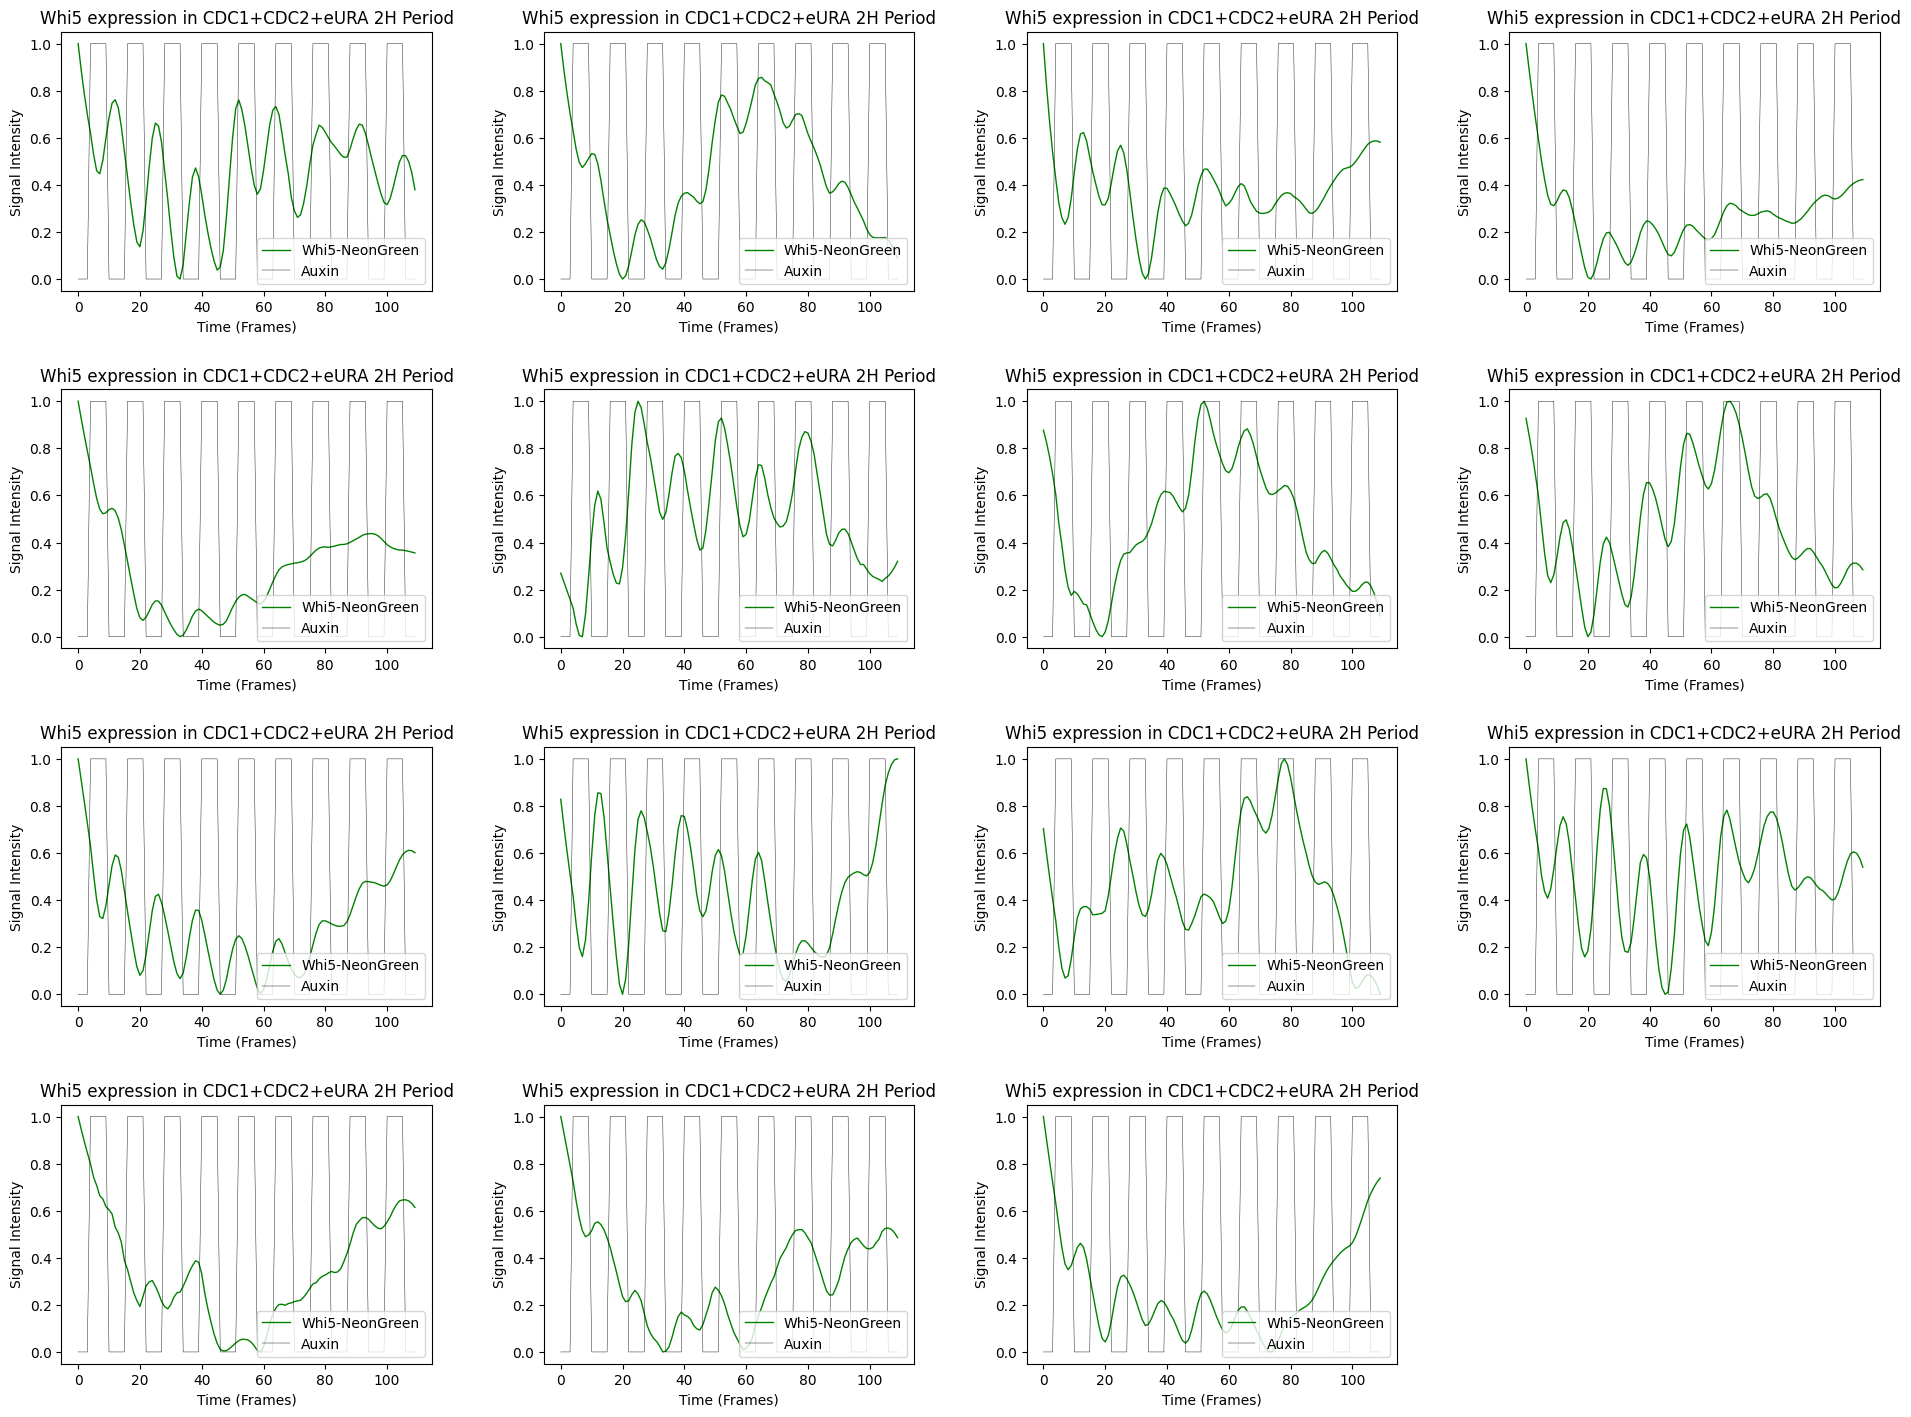

In [18]:
plot_processed_data(cdc2_data, auxin_signal, 'Whi5 expression in CDC1+CDC2+eURA 2H Period')

Check for different parameters such as Phase Shift, Period and Amplitude

In [19]:
Whi5_Auxin_ps = signal_ps(cdc2_data, auxin_signal, frames)

In [20]:
cdc2_period = per_amp_analysis(cdc2_data)[0]

In [21]:
cdc2_amplitud = per_amp_analysis(cdc2_data)[1]

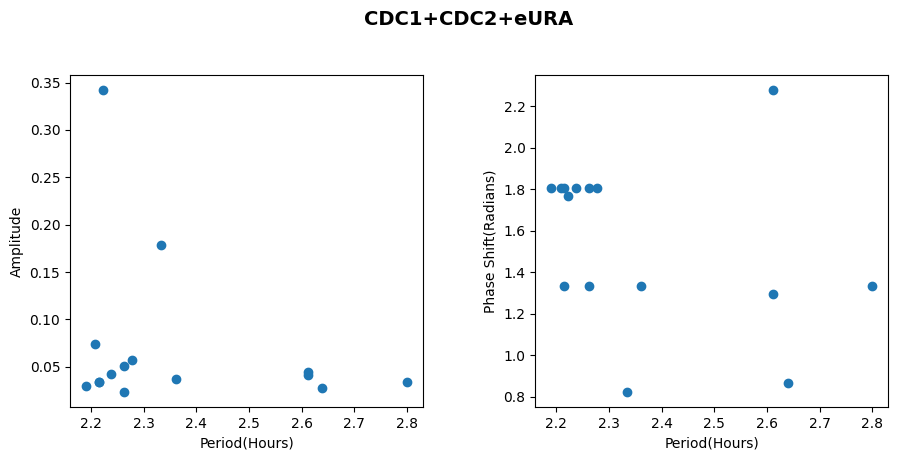

In [22]:
plot_per_amp_ps(cdc2_period, cdc2_amplitud, Whi5_Auxin_ps, 'CDC1+CDC2+eURA')

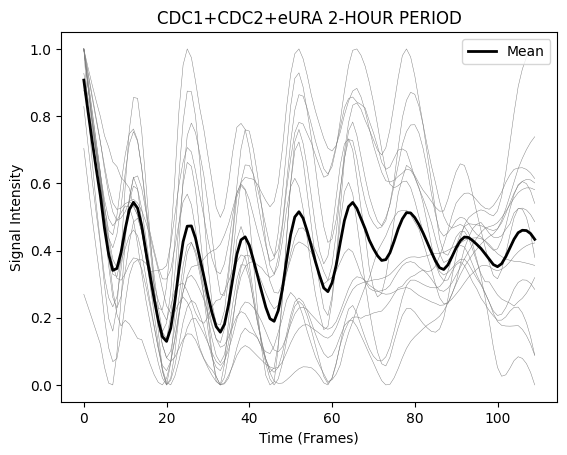

In [23]:
cdc2_mean = mean_analysis(cdc2_data, 'CDC1+CDC2+eURA 2-HOUR PERIOD')

##### CDC1 + CDC2 + eURA **4H PERIOD**

Upload data

In [24]:
pos10 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_4H_v2/Pos10GFP.csv')
pos12 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_4H_v2/Pos12GFP.csv')
pos4 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_4H_v2/Pos4GFP.csv')
pos3 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_4H_v2/Pos3GFP.csv')
pos6 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_4H_v2/Pos6GFP.csv')

pos7 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_4H_v2/Pos7GFP.csv')
pos8 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_4H_v2/Pos8GFP.csv')
pos9 = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/CDC2_4H_v2/Pos9GFP.csv')

cdc2_4h= [pos3, pos4, pos6, pos7, pos8, pos9, pos10, pos12]
frames = np.linspace(0, 190, 191)

Generate auxin signal array

In [25]:
auxin_signal = auxin(12,12,200, 10, 200)

Process the experimental data using data_processing function defined previously

In [26]:
cdc2_4hdata = data_processing(cdc2_4h)

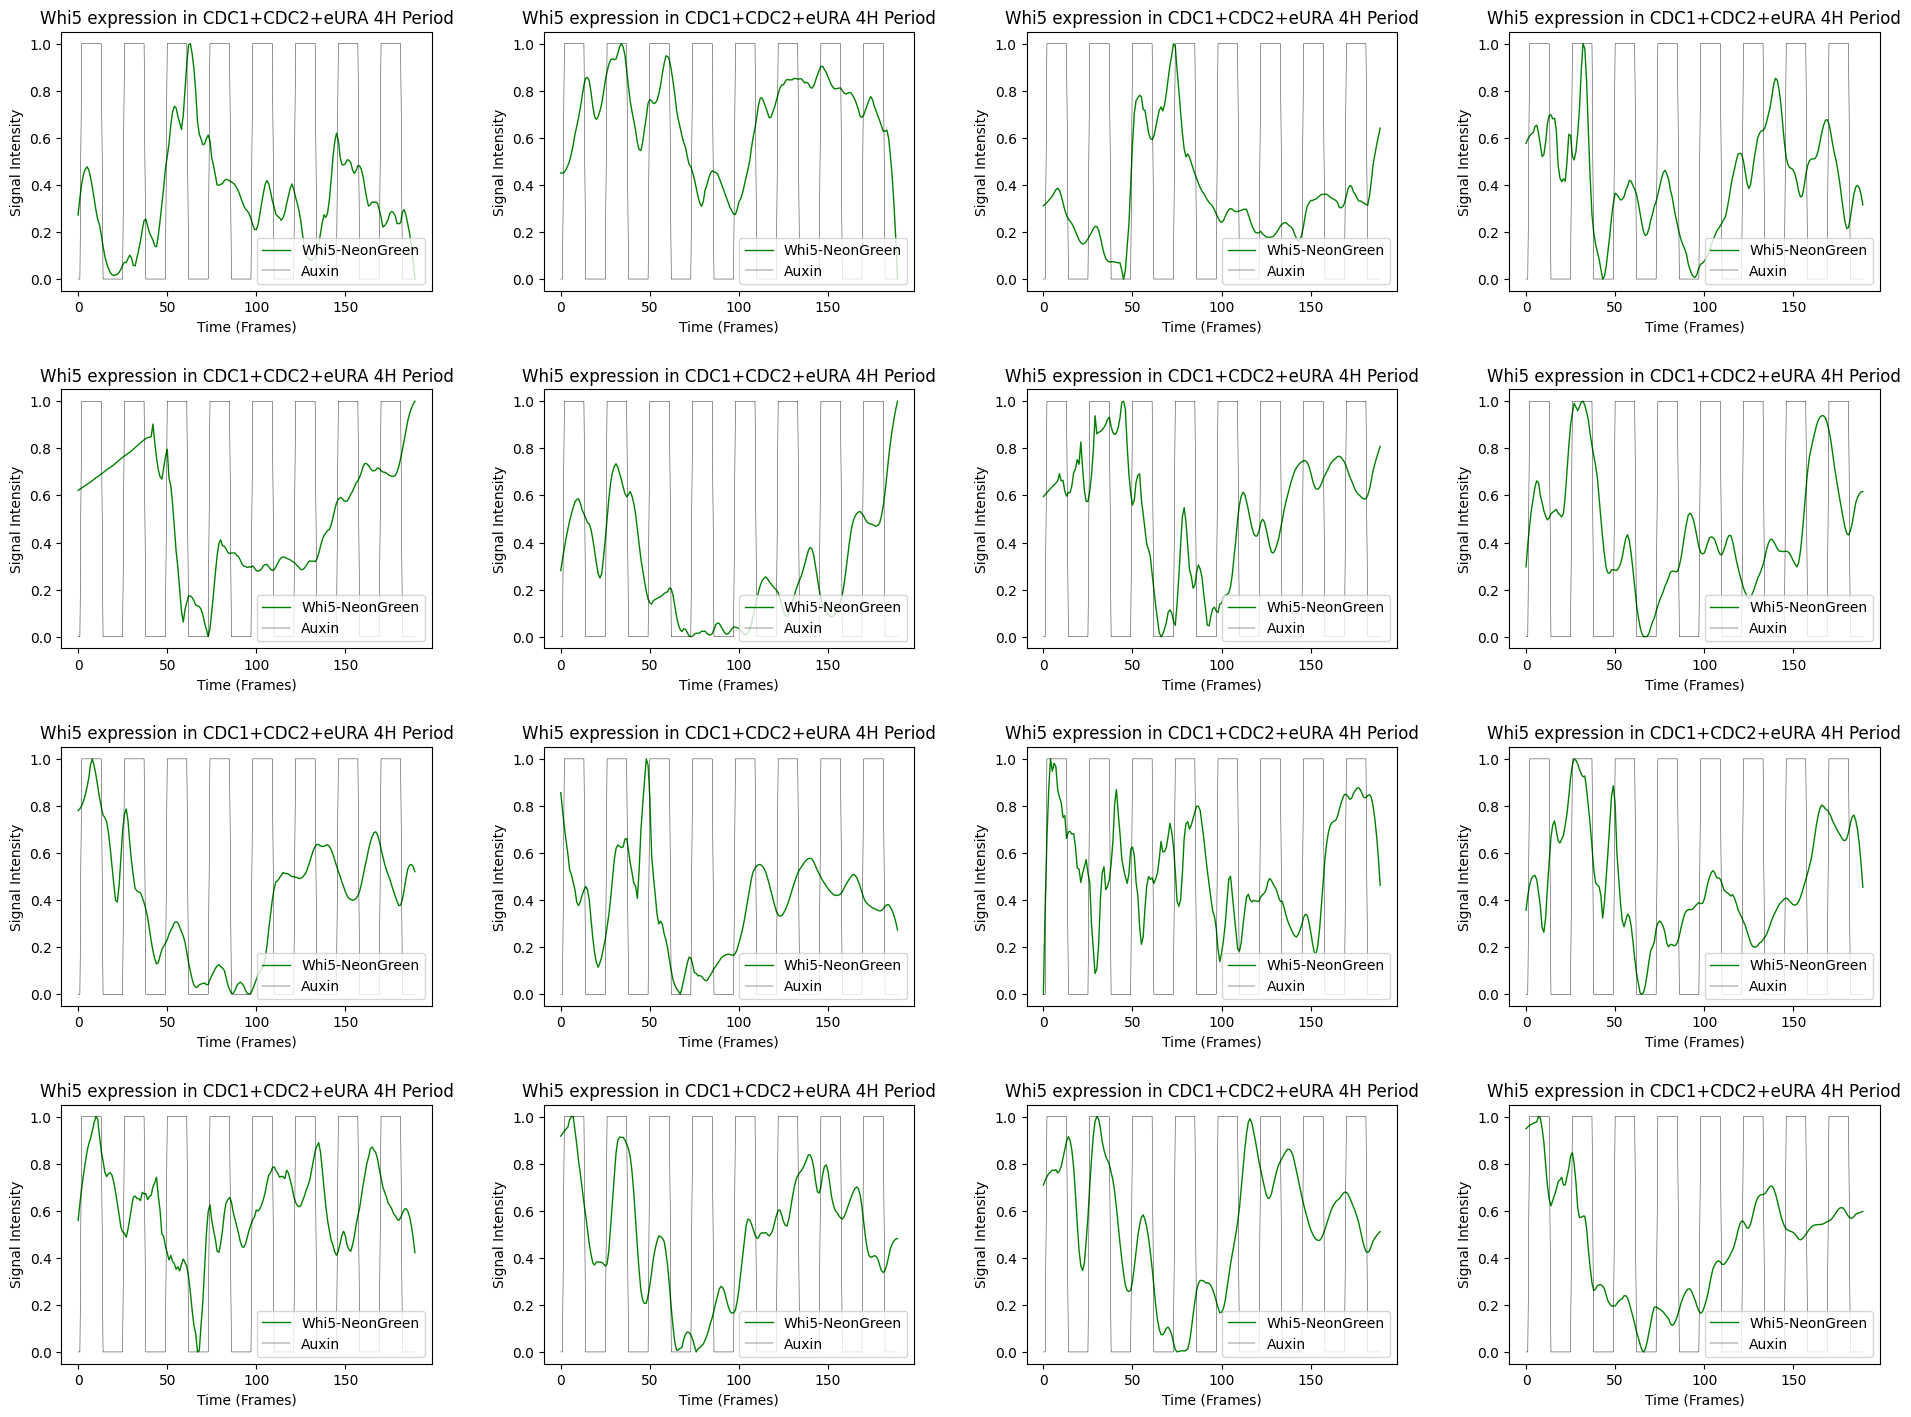

In [27]:
plot_processed_data(cdc2_4hdata, auxin_signal, 'Whi5 expression in CDC1+CDC2+eURA 4H Period')

Check for different parameters such as Phase Shift, Period and Amplitude

In [28]:
Whi5_Auxin_ps4h = signal_ps(cdc2_4hdata, auxin_signal, frames)

In [29]:
cdc2_4hperiod = per_amp_analysis(cdc2_4hdata)[0]

In [30]:
cdc2_4hamplitud = per_amp_analysis(cdc2_4hdata)[1]

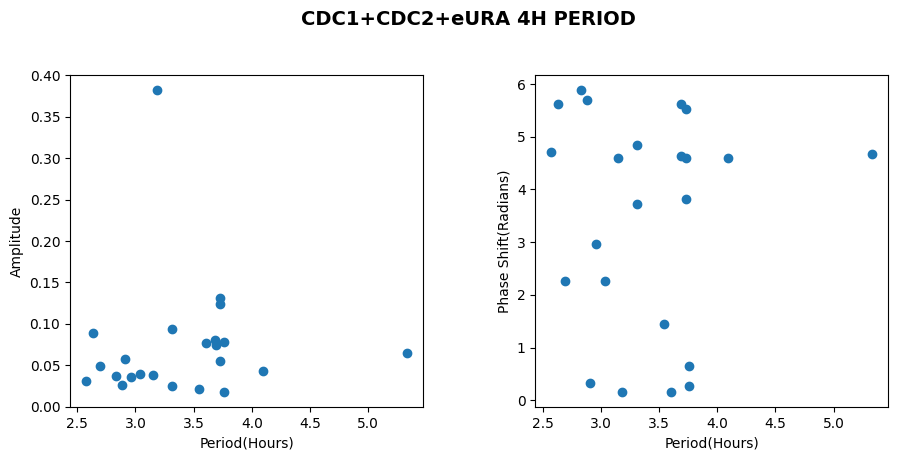

In [31]:
plot_per_amp_ps(cdc2_4hperiod, cdc2_4hamplitud, Whi5_Auxin_ps4h, 'CDC1+CDC2+eURA 4H PERIOD')

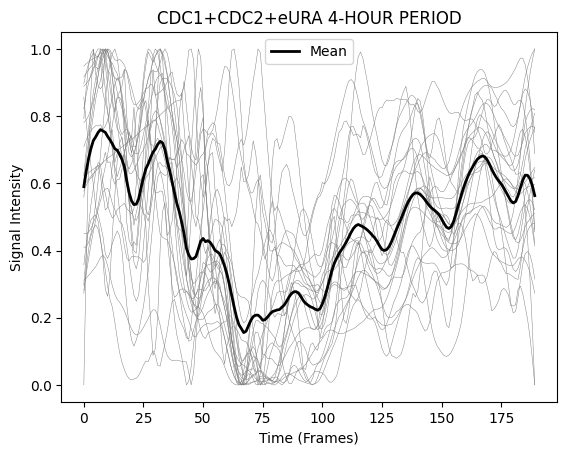

In [32]:
cdc2_4hmean = mean_analysis(cdc2_4hdata, 'CDC1+CDC2+eURA 4-HOUR PERIOD')

##### CDC1 + CDC3 + Neur4 **2H PERIOD**

Upload data

In [33]:
pos30_GFP = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_2H/Pos30GFP.csv')
pos33_GFP = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_2H/Pos33GFP.csv')
pos36_GFP = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_2H/Pos36GFP.csv')
pos38_GFP = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_2H/Pos38GFP.csv')
pos41_GFP = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_2H/Pos41GFP.csv')

GFP_2H_Neur4 = [pos30_GFP, pos33_GFP, pos36_GFP, pos38_GFP, pos41_GFP]

In [34]:
pos30_mCherry = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_2H/Pos30mcherry.csv')
pos33_mCherry = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_2H/Pos33mcherry.csv')
pos36_mCherry = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_2H/Pos36mcherry.csv')
pos38_mCherry = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_2H/Pos38mcherry.csv')
pos41_mCherry = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_2H/Pos41mcherry.csv')

mCherry_2H_Neur4 = [pos30_mCherry, pos33_mCherry, pos36_mCherry, pos38_mCherry, pos41_mCherry]

Generate auxin signal

In [35]:
frames = np.linspace(0, 110, 111)

In [36]:
auxin_2h = auxin(6, 6, 110, 10, 110)

Process the experimental data using data_processing function defined previously

In [37]:
neur4_gfp_2hdata = data_processing(GFP_2H_Neur4)

In [38]:
neur4_mcherry_2hdata = data_processing(mCherry_2H_Neur4)

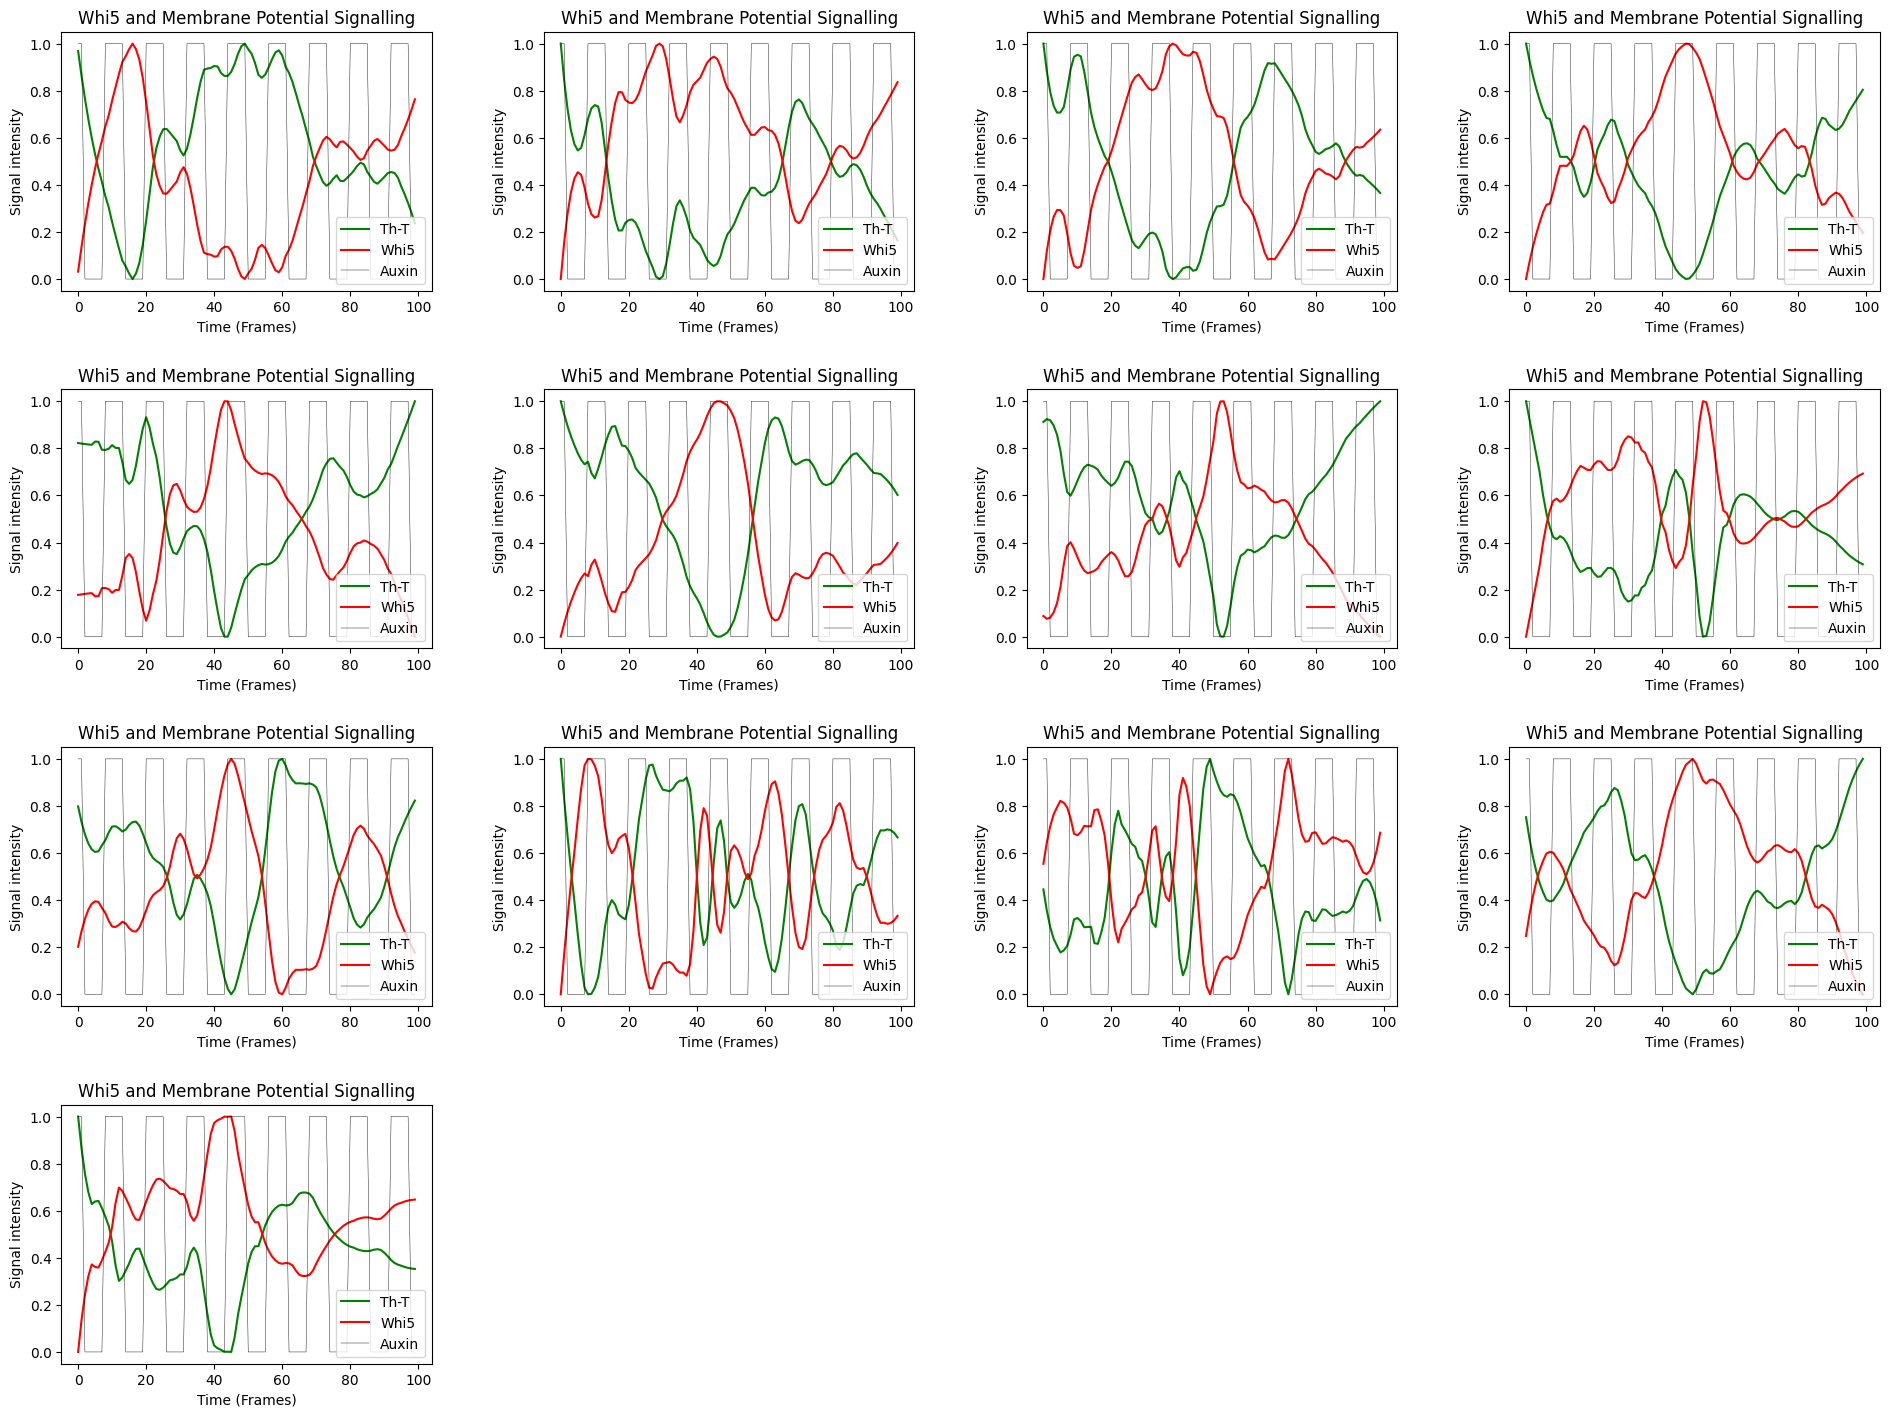

In [39]:
plot_twosignals_data(neur4_gfp_2hdata, neur4_mcherry_2hdata, auxin_2h)

Check for different parameters such as Phase Shift, Period and Amplitude

In [40]:
mCherry_Auxin_ps2h = signal_ps(neur4_mcherry_2hdata, auxin_2h, frames)

In [41]:
GFP_Auxin_ps2h = signal_ps(neur4_gfp_2hdata, auxin_2h, frames)

In [42]:
mCherry_period = per_amp_analysis(neur4_mcherry_2hdata)[0]

In [43]:
GFP_period = per_amp_analysis(neur4_gfp_2hdata)[0]

In [44]:
mCherry_GFP_2h_ps = mCherry_GFP_phase_shift(neur4_gfp_2hdata, neur4_mcherry_2hdata)

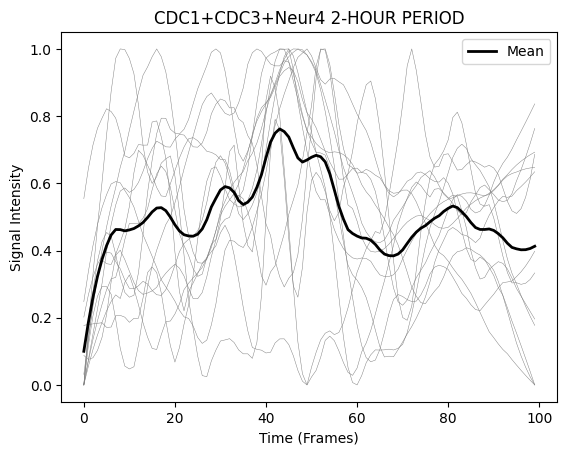

In [45]:
neur4_mean = mean_analysis(neur4_mcherry_2hdata, 'CDC1+CDC3+Neur4 2-HOUR PERIOD')

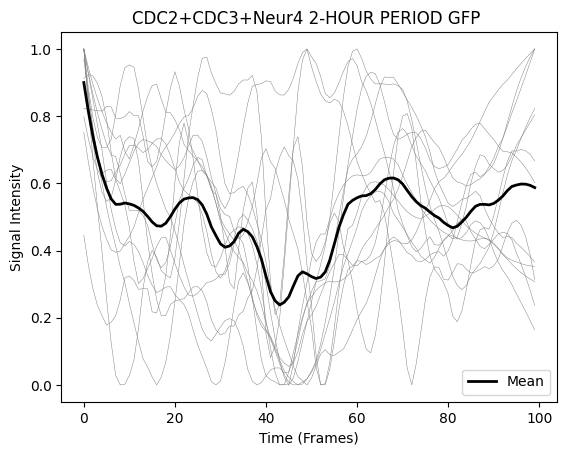

In [46]:
neur4_GFP_mean = mean_analysis(neur4_gfp_2hdata, 'CDC2+CDC3+Neur4 2-HOUR PERIOD GFP ')

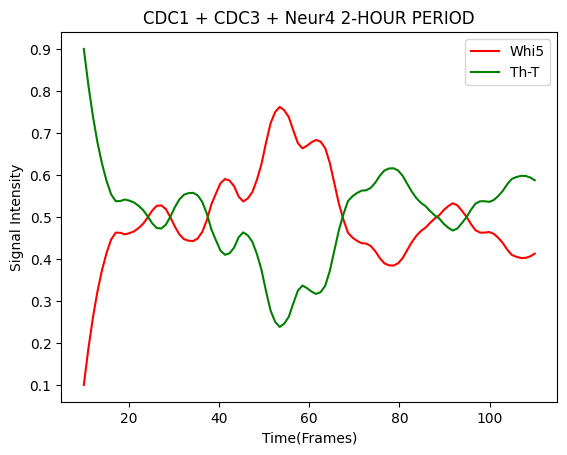

In [47]:
frames = np.linspace(10, 110, 100)
mean_analysis_plot(neur4_mcherry_2hdata, neur4_gfp_2hdata, 'CDC1 + CDC3 + Neur4 2-HOUR PERIOD')

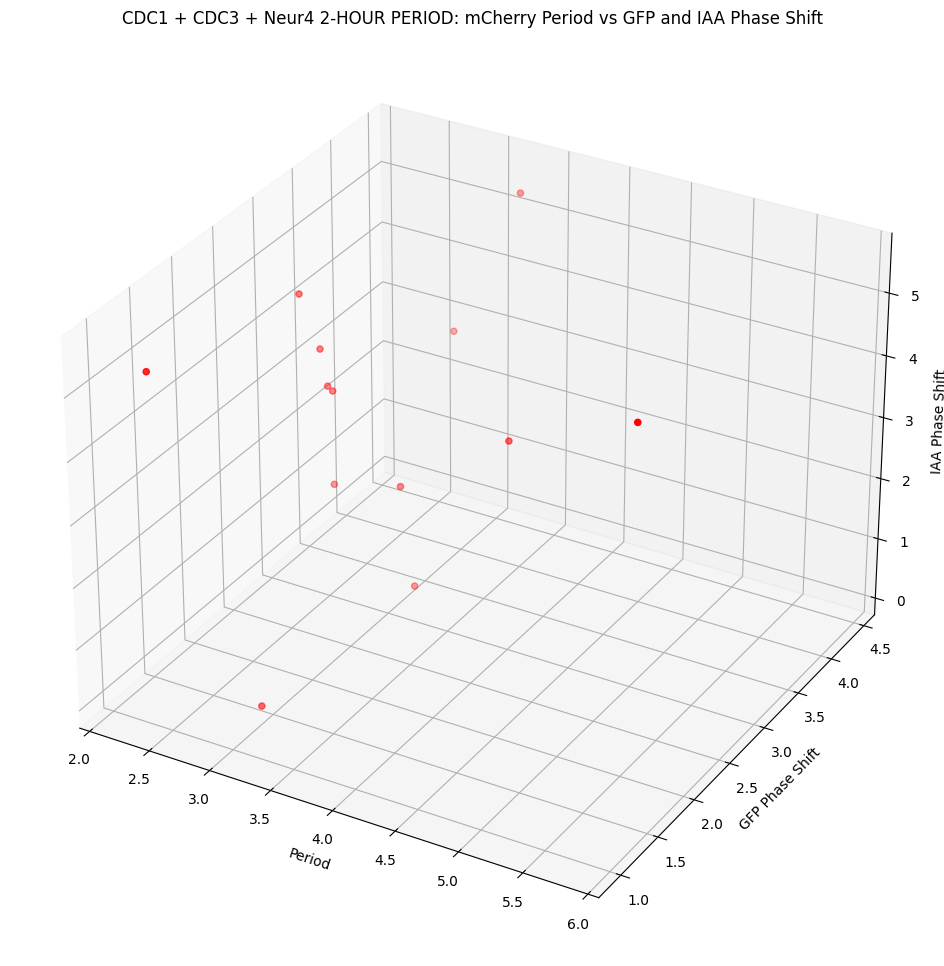

In [48]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(projection='3d')
ax.scatter(mCherry_period, mCherry_GFP_2h_ps, mCherry_Auxin_ps2h , c='red', marker='o')
ax.set_xlabel('Period')
ax.set_xlim(2, 6)
ax.set_ylabel('GFP Phase Shift')
ax.set_zlabel('IAA Phase Shift')
ax.set_title('CDC1 + CDC3 + Neur4 2-HOUR PERIOD: mCherry Period vs GFP and IAA Phase Shift')

plt.savefig('Phase_shift_x2_vsperiod_2H')

##### CDC1 + CDC3 + Neur4 **4H PERIOD**

Upload data

In [49]:
pos16_GFP = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_4H/Pos16GFP.csv')
pos17_GFP = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_4H/Pos17GFP.csv')
pos24_GFP = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_4H/Pos24GFP.csv')
pos26_GFP = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_4H/Pos26GFP.csv')
pos32_GFP = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_4H/Pos32GFP.csv')
pos37_GFP = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_4H/Pos37GFP.csv')

GFP_4H_Neur4 = [pos16_GFP, pos17_GFP, pos24_GFP, pos26_GFP, pos32_GFP, pos37_GFP]

In [50]:
pos16_mCherry = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_4H/Pos16mcherry.csv')
pos17_mCherry = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_4H/Pos17mcherry.csv')
pos24_mCherry = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_4H/Pos24mcherry.csv')
pos26_mCherry = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_4H/Pos26mcherry.csv')
pos32_mCherry = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_4H/Pos32mcherry.csv')
pos37_mCherry = pd.read_csv(r'/content/drive/MyDrive/MARIAM/SCRIPTS/Neur4_4H/Pos37mcherry.csv')

mCherry_4H_Neur4 = [pos16_mCherry, pos17_mCherry, pos24_mCherry, pos26_mCherry, pos32_mCherry, pos37_mCherry]

Generate auxin signal

In [51]:
frames = np.linspace(0, 110, 111)

In [52]:
auxin_4h = auxin(12, 12, 110, 10, 110)

Process the experimental data using data_processing function defined previously

In [53]:
neur4_gfp_4hdata = data_processing(GFP_4H_Neur4)

In [54]:
neur4_mcherry_4hdata = data_processing(mCherry_4H_Neur4)

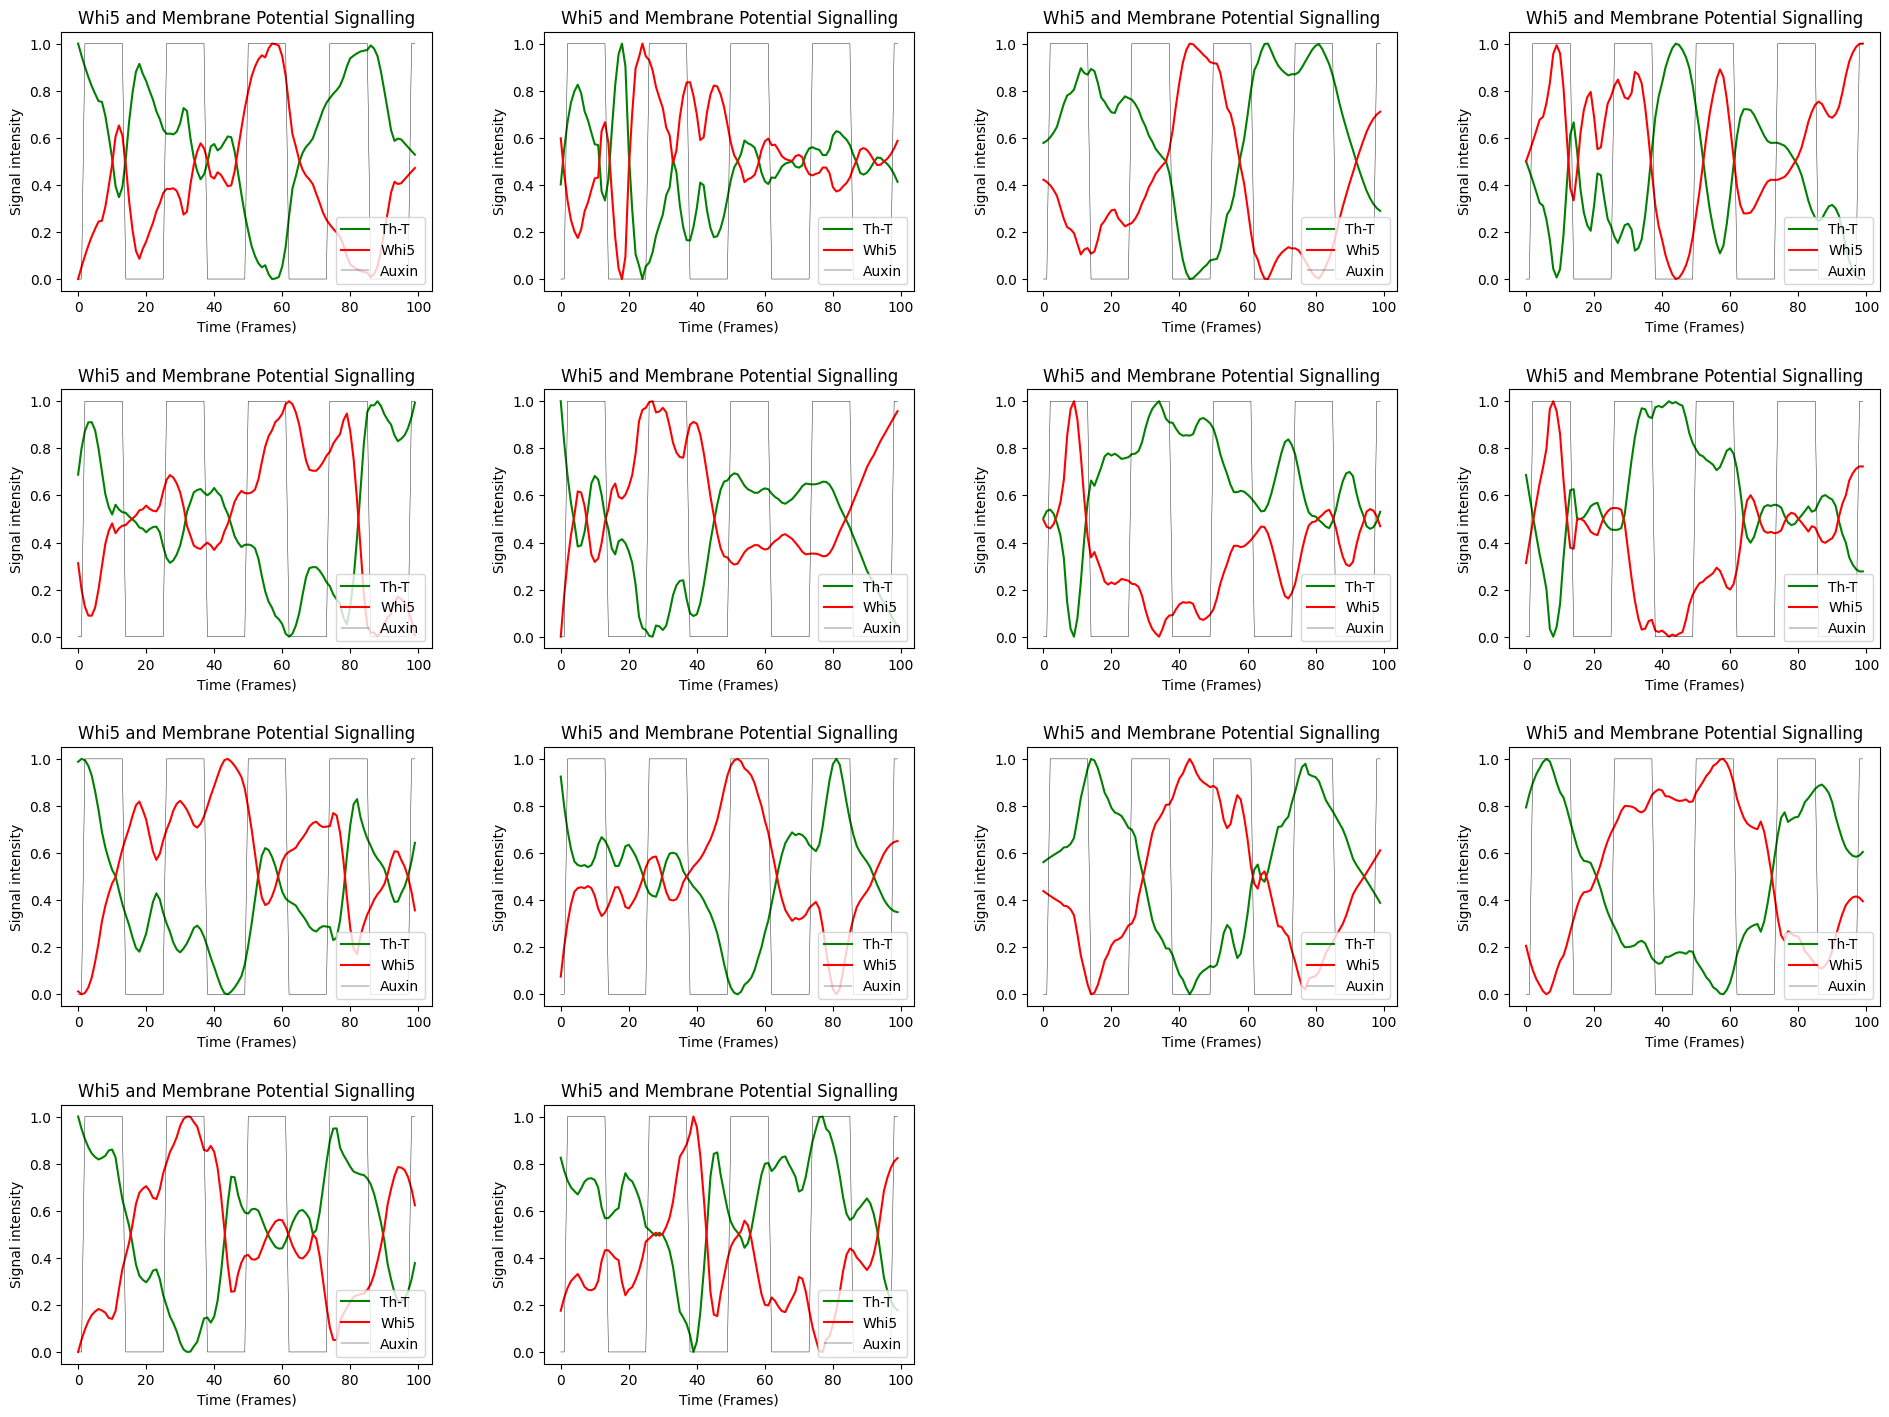

In [55]:
plot_twosignals_data(neur4_gfp_4hdata, neur4_mcherry_4hdata, auxin_4h)

Check for different parameters such as Phase Shift, Period and Amplitude

In [56]:
mCherry_Auxin_ps4h = signal_ps(neur4_mcherry_4hdata, auxin_4h, frames)

In [57]:
GFP_Auxin_ps4h = signal_ps(neur4_gfp_4hdata, auxin_4h, frames)

In [58]:
mCherry_period_4H = per_amp_analysis(neur4_mcherry_4hdata)[0]

In [59]:
GFP_period_4H = per_amp_analysis(neur4_gfp_4hdata)[0]

In [60]:
mCherry_GFP_4h_ps = mCherry_GFP_phase_shift(neur4_gfp_4hdata, neur4_mcherry_4hdata)

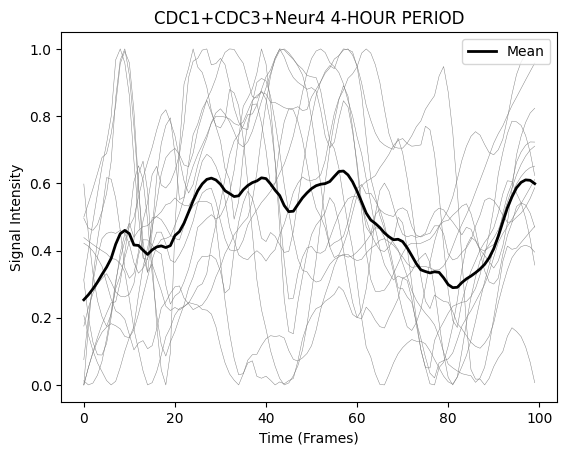

In [61]:
neur4_4h_mCherry_mean = mean_analysis(neur4_mcherry_4hdata, 'CDC1+CDC3+Neur4 4-HOUR PERIOD')

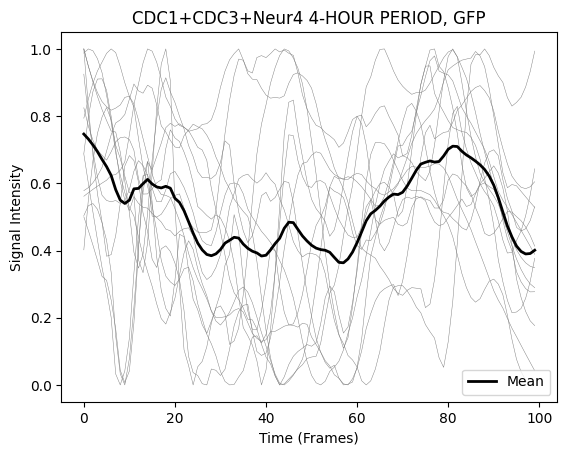

In [62]:
neur4_4h_GFP_mean = mean_analysis(neur4_gfp_4hdata, 'CDC1+CDC3+Neur4 4-HOUR PERIOD, GFP')

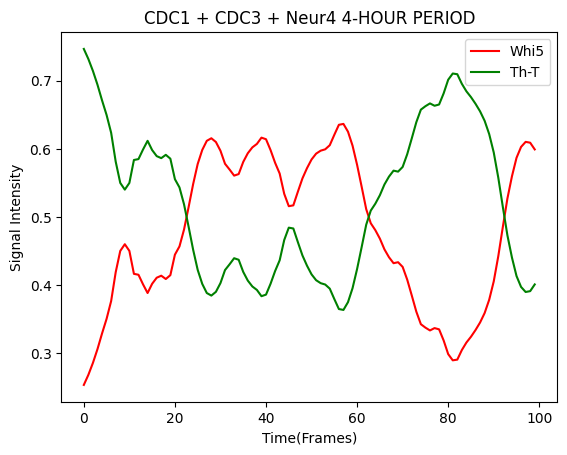

In [63]:
frames = np.linspace(0, 110, 111)
mean_analysis_plot(neur4_mcherry_4hdata, neur4_gfp_4hdata, 'CDC1 + CDC3 + Neur4 4-HOUR PERIOD')

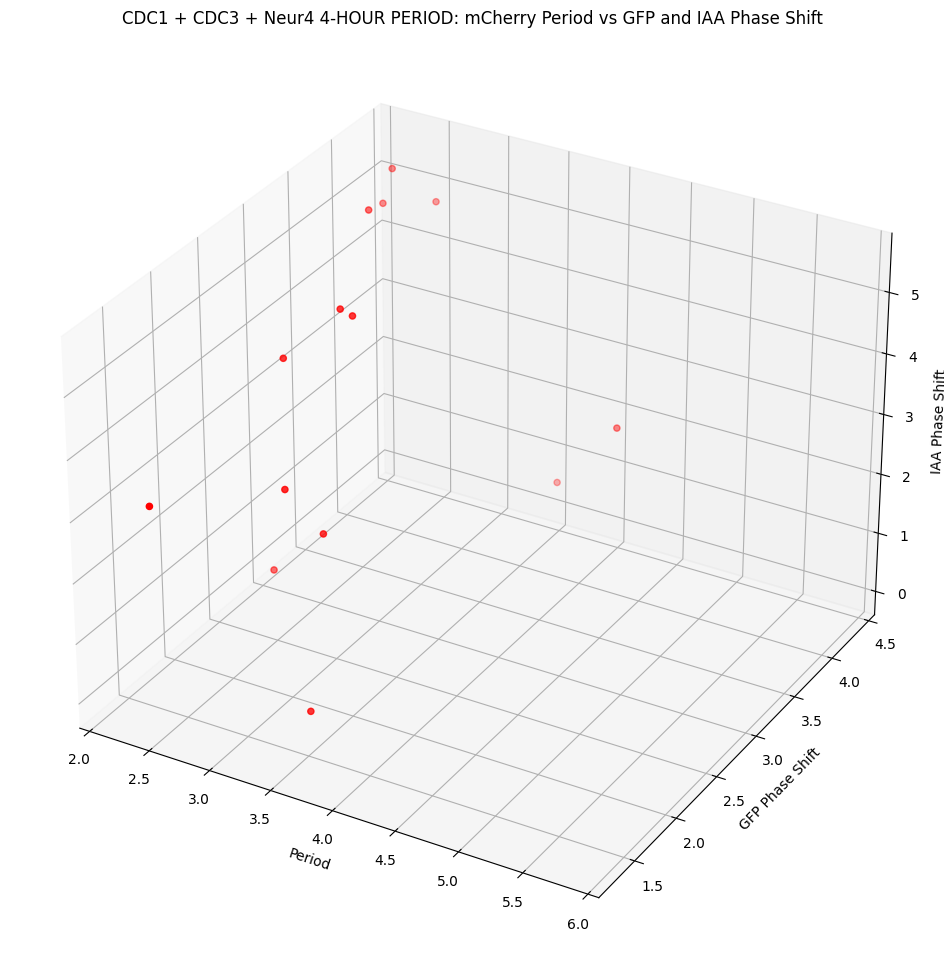

In [64]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(projection='3d')
ax.scatter(mCherry_period_4H, mCherry_GFP_4h_ps, mCherry_Auxin_ps4h , c='red', marker='o')
ax.set_xlabel('Period')
ax.set_xlim(2, 6)
ax.set_ylabel('GFP Phase Shift')
ax.set_zlabel('IAA Phase Shift')
ax.set_title('CDC1 + CDC3 + Neur4 4-HOUR PERIOD: mCherry Period vs GFP and IAA Phase Shift')

plt.savefig('Phase_shift_x2_vsperiod_4H')

#### **Compare conditions**

**Perform statistical test to check if there are significative differences between conditions**

BETWEEN 2-HOUR PERIOD AND 4-HOUR PERIOD

In [65]:
def period_statistics(list1, list2, title):
  t_statistic, p_value = stats.ttest_ind(list1, list2, equal_var=False)

  # Print the results
  print("Welch's t-test results for", title,"strain:\nT-statistic is equal to", t_statistic," and P-value is equal to", p_value)

  if p_value > 0.05:
    print('\nThere are no significative differences')
  else:
    print('\nThere are significative differences')

In [66]:
period_statistics(cdc2_period, cdc2_4hperiod, "CDC1 + CDC2 + eURA")

Welch's t-test results for CDC1 + CDC2 + eURA strain:
T-statistic is equal to -7.594094093134709  and P-value is equal to 2.4608797607908813e-08

There are significative differences


mCherry signalling

In [67]:
period_statistics(mCherry_period, mCherry_period_4H, "CDC1 + CDC3 + Neur4")

Welch's t-test results for CDC1 + CDC3 + Neur4 strain:
T-statistic is equal to 0.9100217198685059  and P-value is equal to 0.373585496120148

There are no significative differences


GFP signalling

In [68]:
period_statistics(GFP_period, GFP_period_4H, "CDC1 + CDC3 + NEUR4")

Welch's t-test results for CDC1 + CDC3 + NEUR4 strain:
T-statistic is equal to 0.6522055783331703  and P-value is equal to 0.5221039952958841

There are no significative differences
